In [31]:
{"tags": ["hide-output" ]}

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

In this example, we will simulate synthetic data as realizations of non-stationary Geometric Brownian Motion (GBM).

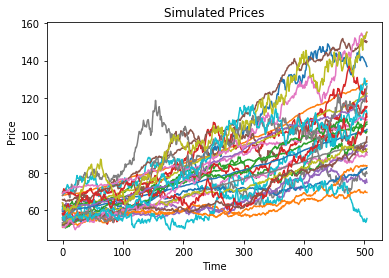

In [2]:
def SimulateGBM(P0 = 50, n=252, T=3, mu=0.2, sigma=0.15):
    """
    Simulates a realization of GBM via discrete approximation.
    
    Parameters
    ----------
        P0    (float)  Initial value
        n     (int)    Number of observations per year
        T     (int)    Number of years
        mu    (float)  Deterministic drift dynamics
        sigma (float) Stochastic volatility dynamics
    """
    dt = T / n
    deltaPt = np.exp( (mu - (sigma**2 / 2))*dt + sigma*np.random.normal(0, np.sqrt(dt), size=(1, n*T)).T )
    deltaPt = np.vstack([1, deltaPt]).cumprod(axis=0)
    Pt = P0 * deltaPt
    return Pt

n = 252
T = 2
K = 30  # Number of features/prices
df = []
for k in range(K):
    Pk_0 = np.random.uniform(50,70)
    mu_k = np.random.normal(0.15,0.025)
    sigma_k = abs(np.random.normal(0.1, 0.1))
    P_k = SimulateGBM(P0=Pk_0, mu=mu_k, sigma=sigma_k, n=n, T=T)
    df.append( P_k )
df = pd.DataFrame( np.hstack(df) )
df.plot(title='Simulated Prices', xlabel='Time', ylabel='Price', legend=False)
plt.show()

We can see that the data is clearly non-stationary. Now let's say we hypothesized that current period prices are predictive of the next period's log-returns.

In [3]:
# Compute log-returns
Y = np.log(df) - np.log(df.shift(1))
Y = Y.shift(-1)
Y = Y.iloc[:-1]

# Features: Current period prices
X = df.iloc[:-1,:]

# Split into training/validation
test_size = 0.2
train_idx = X.index[:int( (1-test_size) * len(X.index) )]
test_idx = X.index[int( (1-test_size) * len(X.index) ):]
X_train, X_test, Y_train, Y_test = X.loc[train_idx,:], X.loc[test_idx,:], Y.loc[train_idx,:], Y.loc[test_idx,:]

Using a very simple linear model for illustration:

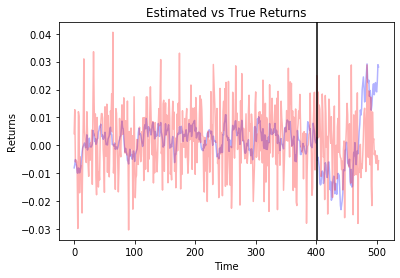

In [4]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, Y_train)
Y_train_hat = reg.predict(X_train)
Y_test_hat = reg.predict(X_test)

# Plot the first price series predictions
y1_hat = np.concatenate([Y_train_hat[:,0], Y_test_hat[:,0]], axis=0)
y1_true = np.concatenate([Y_train.values[:,0], Y_test.values[:,0]], axis=0)
idx = np.concatenate([train_idx.values, test_idx.values], axis=0)

plt.plot(idx, y1_hat, color='blue', alpha=0.3)
plt.plot(idx, y1_true, color='red', alpha=0.3)
plt.title('Estimated vs True Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.axvline(train_idx.values[-1],color='black')
plt.show()

Red indicates true returns, blue the estimates. In-sample predictions are to the left of the black line, and we can see that out-of-sample predictions deteriorate quickly due to the nonstationarity. <br> A common way of handling this is to stationarize the features by taking the first difference as follows:

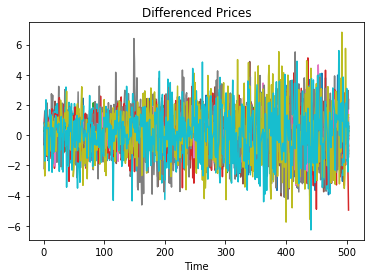

In [5]:
X_diff = X.diff(1)
X_diff.plot(title='Differenced Prices', xlabel='Time', legend=False)
plt.show()

Compared to the original plot of `df`, this looks much more stable. However, much of the information in the original prices is lost through this transformation.

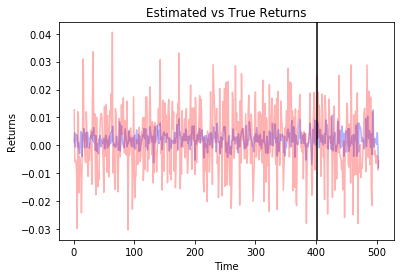

In [6]:
X_diff_train, X_diff_test = X_diff.loc[train_idx,:], X_diff.loc[test_idx,:]

X_diff_train = X_diff_train.iloc[1:,:]  # Drop first obs as it is NaN
Y_train_aligned = Y_train.iloc[1:,:]

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_diff_train, Y_train_aligned)
Y_train_hat = reg.predict(X_diff_train)
Y_test_hat = reg.predict(X_diff_test)

# Plot the first price series predictions
y1_hat = np.concatenate([Y_train_hat[:,0], Y_test_hat[:,0]], axis=0)
y1_true = np.concatenate([Y_train_aligned.values[:,0], Y_test.values[:,0]], axis=0)
idx = np.concatenate([train_idx.values[1:], test_idx.values], axis=0)

plt.plot(idx, y1_hat, color='blue', alpha=0.3)
plt.plot(idx, y1_true, color='red', alpha=0.3)
plt.title('Estimated vs True Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.axvline(train_idx.values[-1],color='black')
plt.show()

Importantly the model now generalizes much better out-of-sample with the stationarized features as the two sets of data are more identically distributed. However we can see that the estimates are close to 0 (sample mean of Y), indicating a lack of informativeness in the features and/or model. <br> Now let's consider fractional differentation using the `tsfracdiff` library.

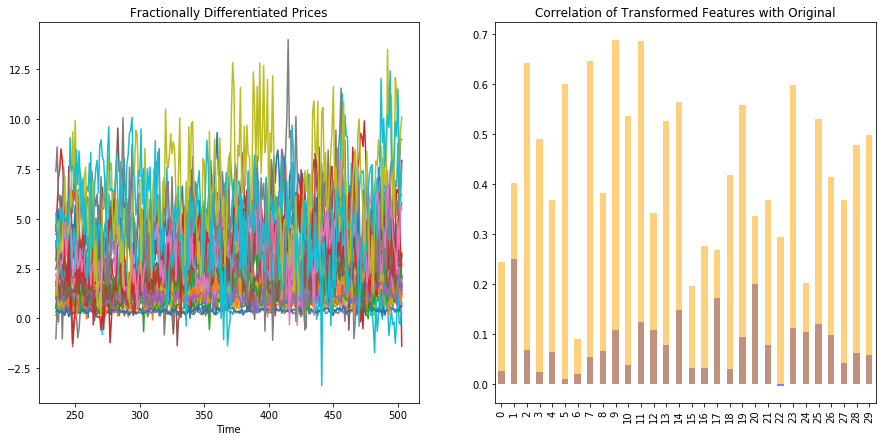

In [29]:
from tsfracdiff import FractionalDifferentiator

# Fractional Differentiate
fracDiff = FractionalDifferentiator()
X_frac = fracDiff.FitTransform(X)

# Estimated orders
fracDiff.orders # Ranges from 0.45 - 0.94, indicating first-difference transformation may be excessive

# Align data
X_frac = X_frac.dropna()
X_frac_train, X_frac_test = X_frac.loc[:train_idx.values[-1],:], X_frac.loc[test_idx.values[0]:,:]
Y_train_aligned = Y_train.loc[X_frac_train.index,:]

fig, ax = plt.subplots(1,2, figsize=(15,7))
X_frac.plot(title='Fractionally Differentiated Prices', xlabel='Time', legend=False, ax=ax[0])
X_diff.corrwith(X).plot(kind='bar', color='blue', alpha=0.5, title='Correlation of Transformed Features with Original', ax=ax[1])
X_frac.corrwith(X).plot(kind='bar', color='orange', alpha=0.5, ax=ax[1])
plt.show()

(Left) The fractionally differenced series are stationary, but are more informative than the pure integer differentiated case. <br> (Right) Orange is fractionally differentiated features, brown is first-differenced features.

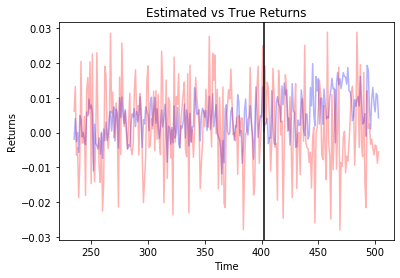

In [10]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_frac_train, Y_train_aligned)
Y_train_hat = reg.predict(X_frac_train)
Y_test_hat = reg.predict(X_frac_test)

# Plot the first price series predictions
y1_hat = np.concatenate([Y_train_hat[:,0], Y_test_hat[:,0]], axis=0)
y1_true = np.concatenate([Y_train_aligned.values[:,0], Y_test.values[:,0]], axis=0)
idx = np.concatenate([X_frac_train.index.values, X_frac_test.index.values], axis=0)

plt.plot(idx, y1_hat, color='blue', alpha=0.3)
plt.plot(idx, y1_true, color='red', alpha=0.3)
plt.title('Estimated vs True Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.axvline(train_idx.values[-1],color='black')
plt.show()

We can see that the fractionally differenced features are more informative than the first-differenced case. Of course, none of the results are particularly good since we used a very simple model. The purpose of this example is to demonstrate the impact on predictive modeling with 1) Non-stationary features that exhibit poor generalization ability if uncorrected for 2) Common first-difference transformations that enable stationarity but potentially with a loss of information 3) Fractional differentiation with `tsfracdiff` as a stationarity transformation that results in minimal loss of information.